## step 1:

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setMaster('local[*]').setAppName('assignment_1')
sc = SparkContext.getOrCreate(conf)

spark = SparkSession(sc)\
        .builder\
        .appName("Assignment 1 Part B")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.assignment1")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.assignment1")\
        .getOrCreate()

## step 2:

In [2]:
import csv

#read csv file
csv_rdd = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header = True)
#clean the empty roll
record_count = csv_rdd.dropna(how = 'all')
the_number_of_record = record_count.count()
print('the number of records in the data frame is :' + str(the_number_of_record))

the number of records in the data frame is :727407


## Step 3:

In [3]:
record_count.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 4:

In [4]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 5:

In [5]:
df.describe('Reported Date', 'Offence Count').show()

+-------+-------------+------------------+
|summary|Reported Date|     Offence Count|
+-------+-------------+------------------+
|  count|       727407|            727407|
|   mean|         null|1.1715174585892079|
| stddev|         null|0.5787050930378103|
|    min|    1/01/2011|                 1|
|    max|    9/12/2018|                 9|
+-------+-------------+------------------+



The max and min value of reported date is not correct. because the reported date is string type not data type, the the max and min is according to the ASCII

## Step 6:

In [6]:

from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType

#define a function to transfer the data to datetype
df_change_type = udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
#use the function to change the data type.
df_date_type = df.withColumn('Reported Date', df_change_type('Reported Date'))
df_date_type.printSchema()



root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 7:

In [7]:
the_number_of_level = df.groupby('Offence Level 2 Description')
the_number_of_level.count().show()

+---------------------------+------+
|Offence Level 2 Description| count|
+---------------------------+------+
|       ROBBERY AND RELAT...|  5848|
|       PROPERTY DAMAGE A...|166161|
|       SEXUAL ASSAULT AN...| 13403|
|       HOMICIDE AND RELA...|   443|
|       ACTS INTENDED TO ...|112961|
|       SERIOUS CRIMINAL ...|104952|
|       OTHER OFFENCES AG...| 23407|
|       FRAUD DECEPTION A...| 19661|
|       THEFT AND RELATED...|280571|
+---------------------------+------+



In [8]:
from pyspark.sql import functions
#select the offence against the person data and sum the offence count
sum_offence = df.where(df['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON').agg(functions.sum('Offence Count')).head()[0]
print('the number of offences against the person is:' + str(sum_offence))

the number of offences against the person is:175644.0


In [9]:
#select the special which is serious criminal trespass, and this data's offence count bigger than 1
property_count = df.where(df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS').filter(df['Offence Count'] > 1).count()
print('the number of serious criminal tresspasses with more than 1 offence count is: ' + str(property_count))

the number of serious criminal tresspasses with more than 1 offence count is: 8579


In [10]:
from pyspark.sql import functions
total = df.agg(functions.sum('Offence Count'))
#select the offence against property and calculate the offenc count
number_property = df.where(df['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY').agg(functions.sum('Offence Count'))
#take the total number of offence count
the_number_of_total = total.select('sum(Offence Count)').head()[0]
#count the all offence count
the_number_of_property = number_property.select('sum(Offence Count)').head()[0]
#calculate the precentage
persentage_1 = str(the_number_of_property/the_number_of_total*100)+'%'
print('the precentage is: ' + str(persentage_1))

the precentage is: 79.3886196416208%


## Step8

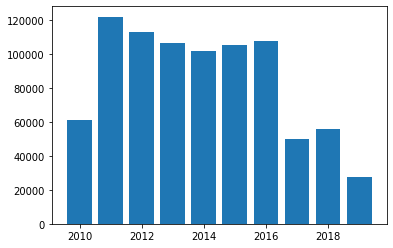

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
#group them by year and count the offence count
year_count =df_date_type.groupby(functions.year('Reported Date').alias('year')).agg(functions.sum('Offence Count')).collect()
x_axis = [row['year'] for row in year_count]
y_axis = [row['sum(Offence Count)'] for row in year_count]
plt.bar(x_axis, y_axis)
plt.show()

the x-axis is the year, the y-axis is the number of crimes per year. Between 2011 and 2016, the offence count is high. This chart indeicates the total number of offence count data per day.

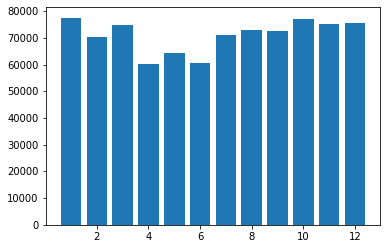

In [12]:
#group them by month and count the offence count
month_count = df_date_type.groupby(functions.month('Reported Date').alias('month')).agg(functions.sum('Offence Count')).collect()
x_axis = [row['month'] for row in month_count]
y_axis = [row['sum(Offence Count)'] for row in month_count]
plt.bar(x_axis, y_axis)
plt.show()

the x-axis is the month,  the y-axis is the offence count. the offence count is minimal at April. This chart indicates the total number of pffence count data per month.

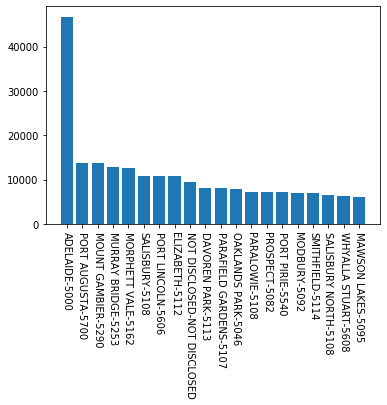

In [13]:
#combine the suburb and postcode
df_combine = df.withColumn('Suburb', functions.concat_ws('-', df['Suburb - Incident'], df['Postcode - Incident']))
#count the offence count and pick the top 20
combine_df = df_combine.groupby('Suburb').agg(functions.sum('Offence Count').alias('Offence Count')).sort('Offence Count', ascending = False).take(20)
#transfer the information into list
x_axis = [row['Suburb'] for row in combine_df]
y_axis = [row['Offence Count'] for row in combine_df]
plt.bar(x_axis, y_axis)
plt.xticks(rotation = 270)
plt.show()

the x-axis is the city name and the post code, the y-axis is the offence count. this graph indicate Adelaide has the higest offence count. This chart indicates the total number of offence count data per suburb

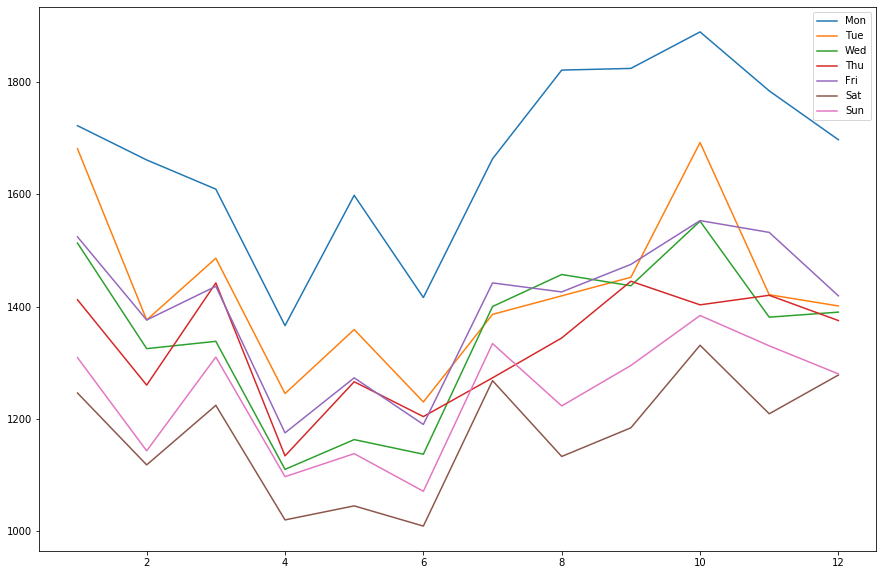

In [14]:
import matplotlib.pyplot as plt
df_date_change = udf(lambda x: datetime.strftime(x, '%a')) #transfer the date into weekday format
df_date_1 = df_date_type.withColumn('month', functions.month('Reported Date')) #take the month out form the date
#get the special information
df_date_1 = df_date_1.withColumn('Reported Date', df_date_change('Reported Date')).filter(df_date_1['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')
#count the offence count
df_date = df_date_1.groupby('month','Reported Date').agg(functions.sum('Offence Count'))
#get the information of each day
Mon = df_date.where(df_date['Reported Date'] == 'Mon').sort('month', ascending = True).collect()
Mon_x_axis = [row['month'] for row in Mon]
Mon_y_axis = [row['sum(Offence Count)'] for row in Mon]
Tue = df_date.where(df_date['Reported Date'] == 'Tue').sort('month', ascending = False).collect()
Tue_x_axis = [row['month'] for row in Tue]
Tue_y_axis = [row['sum(Offence Count)'] for row in Tue]
Wed = df_date.where(df_date['Reported Date'] == 'Wed').sort('month', ascending = False).collect()
Wed_x_axis = [row['month'] for row in Wed]
Wed_y_axis = [row['sum(Offence Count)'] for row in Wed]
Thu = df_date.where(df_date['Reported Date'] == 'Thu').sort('month', ascending = False).collect()
Thu_x_axis = [row['month'] for row in Thu]
Thu_y_axis = [row['sum(Offence Count)'] for row in Thu]
Fri = df_date.where(df_date['Reported Date'] == 'Fri').sort('month', ascending = False).collect()
Fri_x_axis = [row['month'] for row in Fri]
Fri_y_axis = [row['sum(Offence Count)'] for row in Fri]
Sat = df_date.where(df_date['Reported Date'] == 'Sat').sort('month', ascending = False).collect()
Sat_x_axis = [row['month'] for row in Sat]
Sat_y_axis = [row['sum(Offence Count)'] for row in Sat]
Sun = df_date.where(df_date['Reported Date'] == 'Sun').sort('month', ascending = False).collect()
Sun_x_axis = [row['month'] for row in Sun]
Sun_y_axis = [row['sum(Offence Count)'] for row in Sun]
#plot the figure for each day
plt.figure(figsize = (15,10))
plt.plot(Mon_x_axis, Mon_y_axis, label = 'Mon')
plt.plot(Tue_x_axis, Tue_y_axis, label = 'Tue')
plt.plot(Wed_x_axis, Wed_y_axis, label = 'Wed')
plt.plot(Thu_x_axis, Thu_y_axis, label = 'Thu')
plt.plot(Fri_x_axis, Fri_y_axis, label = 'Fri')
plt.plot(Sat_x_axis, Sat_y_axis, label = 'Sat')
plt.plot(Sun_x_axis, Sun_y_axis, label = 'Sun')
plt.legend()
plt.show()

This table shows the trend of the change count for each week in each month. x-axis is the month, the y-axis is the offence count.